In [14]:
import pandas as pd
import numpy as np

In [15]:
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

df = pd.DataFrame(data)
print("Dataset:")
print(df)

Dataset:
     Outlook Temperature Humidity    Wind PlayTennis
0      Sunny         Hot     High    Weak         No
1      Sunny         Hot     High  Strong         No
2   Overcast         Hot     High    Weak        Yes
3       Rain        Mild     High    Weak        Yes
4       Rain        Cool   Normal    Weak        Yes
5       Rain        Cool   Normal  Strong         No
6   Overcast        Cool   Normal  Strong        Yes
7      Sunny        Mild     High    Weak         No
8      Sunny        Cool   Normal    Weak        Yes
9       Rain        Mild   Normal    Weak        Yes
10     Sunny        Mild   Normal  Strong        Yes
11  Overcast        Mild     High  Strong        Yes
12  Overcast         Hot   Normal    Weak        Yes
13      Rain        Mild     High  Strong         No


In [16]:
def calculate_entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [17]:
def calculate_information_gain(data, split_attribute_name, target_name):
    total_entropy = calculate_entropy(data[target_name])

    vals, counts = np.unique(data[split_attribute_name], return_counts=True)

    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * calculate_entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])

    information_gain = total_entropy - weighted_entropy
    return information_gain

In [18]:
def id3(data, original_data, features, target_attribute_name, parent_node_class=None):
    # Base case 1: If all target values are the same, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # Base case 2: If the dataset is empty, return the majority class of the original dataset
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]

    # Base case 3: If the feature space is empty, return the majority class of the parent node
    elif len(features) == 0:
        return parent_node_class

    # If none of the above, construct the tree
    else:
        # Set the default parent node class to the majority class of the current dataset
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]

        # Select the feature that best splits the dataset
        item_values = [calculate_information_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        # Create the tree structure as a dictionary
        tree = {best_feature: {}}

        # Remove the feature with the best info gain from the feature space
        features = [i for i in features if i != best_feature]

        # Grow a branch for each value in the best feature
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()

            # Recursive call to ID3
            subtree = id3(sub_data, data, features, target_attribute_name, parent_node_class)
            tree[best_feature][value] = subtree

        return tree

In [19]:
def predict(query, tree, default="Unknown"):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default

            result = tree[key][query[key]]
            if isinstance(result, dict):
                return predict(query, result)
            else:
                return result

In [20]:
# --- Training ---
features = [col for col in df.columns if col != 'PlayTennis']
target = 'PlayTennis'
decision_tree = id3(df, df, features, target)

# --- Print the Tree ---
import pprint
print("Generated Decision Tree:")
pprint.pprint(decision_tree)

# --- Prediction ---
new_query = {'Outlook': 'Sunny', 'Temperature': 'Hot', 'Humidity': 'Normal', 'Wind': 'Weak'}
prediction = predict(new_query, decision_tree)

print(f"\nPrediction for {new_query}: PlayTennis = {prediction}")

# --- Test with another query ---
new_query_2 = {'Outlook': 'Rain', 'Temperature': 'Mild', 'Humidity': 'High', 'Wind': 'Strong'}
prediction_2 = predict(new_query_2, decision_tree)

print(f"Prediction for {new_query_2}: PlayTennis = {prediction_2}")

Generated Decision Tree:
{'Outlook': {'Overcast': 'Yes',
             'Rain': {'Wind': {'Strong': 'No', 'Weak': 'Yes'}},
             'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}}}

Prediction for {'Outlook': 'Sunny', 'Temperature': 'Hot', 'Humidity': 'Normal', 'Wind': 'Weak'}: PlayTennis = Yes
Prediction for {'Outlook': 'Rain', 'Temperature': 'Mild', 'Humidity': 'High', 'Wind': 'Strong'}: PlayTennis = No


In [21]:
!pip install graphviz

In [22]:
import graphviz
from IPython.display import display

In [23]:
node_counter = 0

def add_nodes_edges(tree, dot=None, parent_name=None, edge_label=""):
    global node_counter
    if dot is None:
        dot = graphviz.Digraph()
        dot.attr('node', shape='box', style='rounded', fontname='helvetica')
        dot.attr('edge', fontname='helvetica')

    if isinstance(tree, dict):
        # It's a decision node
        for key, val in tree.items():
            # Create a unique node name for the attribute
            current_node_name = f"node{node_counter}"
            node_counter += 1
            # Add the decision node to the graph
            dot.node(current_node_name, label=key)

            # If it's not the root, draw an edge from its parent
            if parent_name is not None:
                dot.edge(parent_name, current_node_name, label=edge_label)

            # Recurse for the subtree
            add_nodes_edges(val, dot=dot, parent_name=current_node_name)
    else:
        # It's a leaf node
        # Create a unique node name for the leaf
        current_node_name = f"node{node_counter}"
        node_counter += 1
        # Add the leaf node to the graph with a different shape
        dot.node(current_node_name, label=str(tree), shape='ellipse')

        # Draw an edge from its parent
        if parent_name is not None:
            dot.edge(parent_name, current_node_name, label=edge_label)

    return dot

def visualize_tree(tree):
    """
    Creates and displays a visualization of the decision tree.
    """
    global node_counter
    node_counter = 0 # Reset counter for each new visualization
    graph = add_nodes_edges(tree)
    return graph

Decision Tree Visualization:


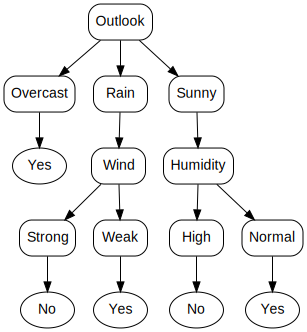

In [24]:
# --- Generate the graph object ---
tree_graph = visualize_tree(decision_tree)

# --- Display the graph in the Colab output ---
print("Decision Tree Visualization:")
display(tree_graph)

## EXPERIMENT-7 : DECISION TREE USING CART ALGO

In [25]:
def calculate_gini(rows):
    counts = Counter(row[-1] for row in rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [26]:
class Question:
    def __init__(self, column, values):
        self.column = column
        self.values = values

    def match(self, example):
        val = example[self.column]
        return val in self.values

    def __repr__(self):
        return f"Is {header[self.column]} in {str(self.values)}?"

class Leaf:
    def __init__(self, rows):
        self.predictions = Counter(row[-1] for row in rows)

class Decision_Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

For each attribute, it finds the best binary partition (e.g., for 'Outlook', it checks splits like {'Sunny'} vs {'Overcast', 'Rain'}) by calculating the Gini Gain for each possibility. It then returns the split that provides the most information.

In [27]:
def partition(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

def find_best_split(rows):
    best_gain = 0
    best_question = None
    current_uncertainty = calculate_gini(rows)
    n_features = len(rows[0]) - 1

    for col in range(n_features):
        values = set(row[col] for row in rows)

        # Generate all non-empty proper subsets for binary splits
        if len(values) > 1:
            for i in range(1, len(values) // 2 + 1):
                for subset in combinations(values, i):
                    question = Question(col, set(subset))

                    true_rows, false_rows = partition(rows, question)
                    if len(true_rows) == 0 or len(false_rows) == 0:
                        continue

                    p = float(len(true_rows)) / len(rows)
                    gain = current_uncertainty - p * calculate_gini(true_rows) - (1 - p) * calculate_gini(false_rows)

                    if gain >= best_gain:
                        best_gain, best_question = gain, question

    return best_gain, best_question

In [28]:
def build_tree(rows):
    gain, question = find_best_split(rows)

    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)

    return Decision_Node(question, true_branch, false_branch)

In [30]:


node_counter_cart = 0

def add_cart_nodes_edges(tree, dot=None):
    global node_counter_cart
    if dot is None:
        dot = graphviz.Digraph()
        dot.attr('node', shape='box', style='rounded', fontname='helvetica')
        dot.attr('edge', fontname='helvetica')

    node_id = str(node_counter_cart)
    node_counter_cart += 1

    if isinstance(tree, Leaf):
        # It's a leaf node
        label = "\n".join([f"{k}: {v}" for k, v in tree.predictions.items()])
        dot.node(node_id, label=label, shape='ellipse')
        return node_id

    # It's a decision node
    dot.node(node_id, label=str(tree.question))

    # Recurse for true branch
    true_child_id = add_cart_nodes_edges(tree.true_branch, dot)
    dot.edge(node_id, true_child_id, label="True")

    # Recurse for false branch
    false_child_id = add_cart_nodes_edges(tree.false_branch, dot)
    dot.edge(node_id, false_child_id, label="False")

    return node_id

def visualize_cart_tree(tree):
    global node_counter_cart
    node_counter_cart = 0
    dot = graphviz.Digraph(comment='CART Decision Tree')
    add_cart_nodes_edges(tree, dot)
    return dot

In [34]:
from collections import Counter
from itertools import combinations

CART Decision Tree Visualization:


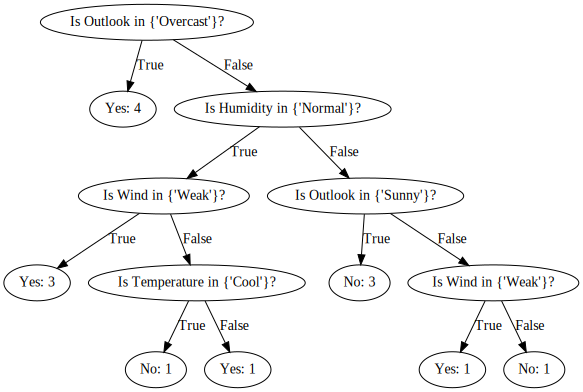

In [35]:
# --- Prepare data and train tree ---
header = list(df.columns)
training_data = df.values.tolist()
cart_tree = build_tree(training_data)

# --- Generate the graph object ---
cart_graph = visualize_cart_tree(cart_tree)

# --- Display the graph in the Colab output ---
print("CART Decision Tree Visualization:")
display(cart_graph)

## EXPERIMENT 8 - C4.5 ALGO

In [36]:
def calculate_entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    if len(elements) <= 1:
        return 0
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

def calculate_information_gain(data, split_attribute_name, target_name):
    total_entropy = calculate_entropy(data[target_name])
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)

    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * calculate_entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])

    information_gain = total_entropy - weighted_entropy
    return information_gain

In [37]:
def calculate_split_info(data, split_attribute_name):
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)

    # Handle the case of a single value to avoid log2(1)=0 issues if it's the only value
    if len(counts) <= 1:
        return 1 # Return 1 to not favor single-valued attributes

    split_info = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(vals))])
    return split_info

def calculate_gain_ratio(data, split_attribute_name, target_name):
    info_gain = calculate_information_gain(data, split_attribute_name, target_name)
    split_info = calculate_split_info(data, split_attribute_name)

    # Avoid division by zero
    if split_info == 0:
        return 0

    gain_ratio = info_gain / split_info
    return gain_ratio

In [38]:
def c45(data, original_data, features, target_attribute_name, parent_node_class=None):
    # Base case 1: If all target values are the same, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # Base case 2: If the dataset is empty, return the majority class of the original dataset
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]

    # Base case 3: If the feature space is empty, return the majority class of the parent node
    elif len(features) == 0:
        return parent_node_class

    # If none of the above, construct the tree
    else:
        # Set the default parent node class to the majority class of the current dataset
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]

        # Select the feature that best splits the dataset using GAIN RATIO
        item_values = [calculate_gain_ratio(data, feature, target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        # Create the tree structure as a dictionary
        tree = {best_feature: {}}

        # Remove the feature with the best gain ratio from the feature space
        features = [i for i in features if i != best_feature]

        # Grow a branch for each value in the best feature
        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()

            # Recursive call to c45
            subtree = c45(sub_data, data, features, target_attribute_name, parent_node_class)
            tree[best_feature][value] = subtree

        return tree

In [39]:
import graphviz
from IPython.display import display

# A counter to create unique node IDs
node_counter = 0

def add_nodes_edges(tree, dot=None, parent_name=None, edge_label=""):
    global node_counter
    if dot is None:
        dot = graphviz.Digraph()
        dot.attr('node', shape='box', style='rounded', fontname='helvetica')
        dot.attr('edge', fontname='helvetica')

    if isinstance(tree, dict):
        # It's a decision node
        for key, val in tree.items():
            current_node_name = f"node{node_counter}"
            node_counter += 1
            dot.node(current_node_name, label=key)

            if parent_name is not None:
                dot.edge(parent_name, current_node_name, label=edge_label)

            add_nodes_edges(val, dot=dot, parent_name=current_node_name)
    else:
        # It's a leaf node
        current_node_name = f"node{node_counter}"
        node_counter += 1
        dot.node(current_node_name, label=str(tree), shape='ellipse')

        if parent_name is not None:
            dot.edge(parent_name, current_node_name, label=edge_label)

    return dot

def visualize_tree(tree):
    global node_counter
    node_counter = 0 # Reset counter for each new visualization
    graph = add_nodes_edges(tree)
    return graph

Generated C4.5 Tree (Dictionary Representation):
{'Outlook': {'Overcast': 'Yes',
             'Rain': {'Wind': {'Strong': 'No', 'Weak': 'Yes'}},
             'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}}}

C4.5 Decision Tree Visualization:


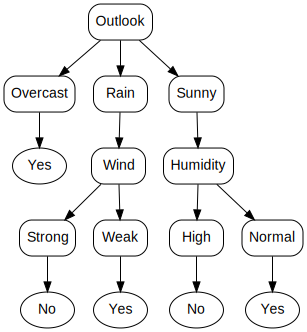

In [40]:
# --- Training ---
features = [col for col in df.columns if col != 'PlayTennis']
target = 'PlayTennis'
c45_tree = c45(df, df, features, target)

# --- Generate the graph object ---
c45_graph = visualize_tree(c45_tree)

# --- Display the graph in the Colab output ---
import pprint
print("Generated C4.5 Tree (Dictionary Representation):")
pprint.pprint(c45_tree)
print("\nC4.5 Decision Tree Visualization:")
display(c45_graph)